# Prophet
Meta(facebook)が公開した時系列予測のためのOSSライブラリ。Pythonでのインストール方法は[**Installation in Python**](https://facebook.github.io/prophet/docs/installation.html#python)を参照してください。基本的には `pip install prophet` を実行すればインストールできます。

In [1]:
# Google　Colaboratory で実行する場合はインストールする
if str(get_ipython()).startswith("<google.colab."):
    !pip install japanize_matplotlib
    !pip install prophet

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib
from prophet import Prophet

In [3]:
# グラフの表示パラメタ
sns.set(
    rc={
        "figure.figsize": (12, 4),
        "legend.fontsize": "large",
        "figure.titlesize": "large",
        "axes.titlesize": 20,
    }
)
japanize_matplotlib.japanize()

## 実験に使用するデータ
１年間のデータを用意します。偶数の月は数値が減少する傾向があります。また、週ごとに周期的な数値を取ります。
2020/1/1 ~ 2020/12/31 の期間のデータです。

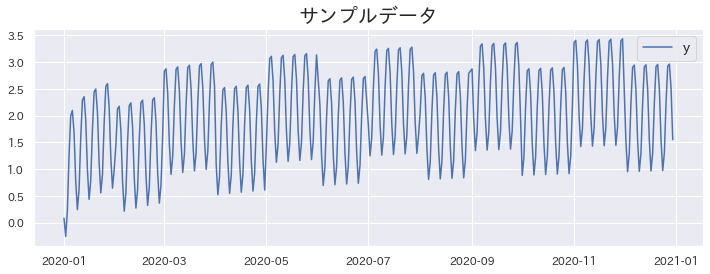

In [4]:
date = pd.date_range("2020-01-01", periods=365, freq="D")
y = [
    np.cos(di.weekday()) + di.month % 2 / 2 + np.log(i + 1) / 3.0
    for i, di in enumerate(date)
]

df = pd.DataFrame({"ds": date, "y": y})
df.index = date

plt.title("サンプルデータ")
sns.lineplot(data=df)
plt.show()

## Prophetで2021年の1~3月を予測する
2020/1/1 ~ 2020/12/31 のデータを使って、さらに先の３ヶ月を予測してみます。
データは一年しかないので `yearly_seasonality=False`、週ごとに周期性が見られるので `daily_seasonality=True`を指定します。

In [5]:
def train_and_forecast_pf(
    data, periods=90, yearly_seasonality=False, daily_seasonality=True
):
    """prophetを訓練して予測をする"""
    assert "ds" in data.columns and "y" in data.columns, "入力するデータにはds, yの列が必要です。"
    # モデルを訓練
    m = Prophet(
        yearly_seasonality=yearly_seasonality, daily_seasonality=daily_seasonality
    )
    m.fit(df)

    # 将来を予測
    future = m.make_future_dataframe(periods=periods)
    forecast = m.predict(future)
    return m, forecast

Initial log joint probability = -33.3545
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      85       768.551   0.000868797       153.932   1.277e-05       0.001      147  LS failed, Hessian reset 
      99       768.591   7.56438e-05       66.5467           1           1      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       768.602   0.000131401       54.4407   1.853e-06       0.001      216  LS failed, Hessian reset 
     166        768.91     0.0010691       162.253   1.714e-05       0.001      324  LS failed, Hessian reset 
     199       768.987   1.55227e-05       65.4344      0.1951      0.1951      376   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     219       769.008   0.000135381       45.0749   2.159e-06       0.001      439  LS failed, Hessian reset 
     299        769.13   5.36783e-05        64.062           1   

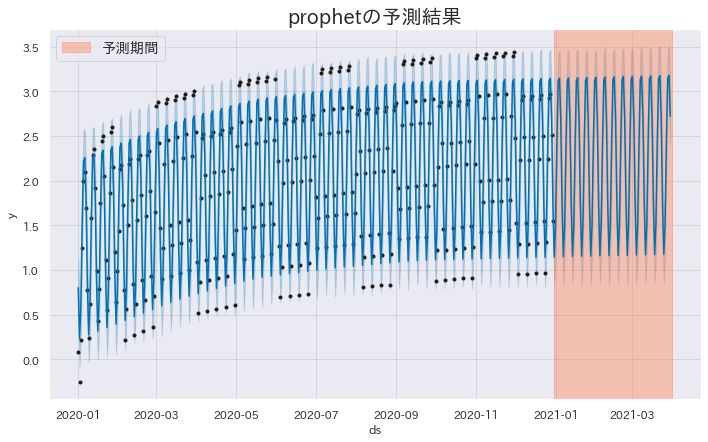

In [6]:
# 予測結果を確認する
periods = 90
m, forecast = train_and_forecast_pf(
    df, periods=periods, yearly_seasonality=False, daily_seasonality=True
)
fig = m.plot(forecast)
plt.title("prophetの予測結果")
plt.axvspan(18627, 18627 + periods, color="coral", alpha=0.4, label="予測期間")
plt.legend()

### 周期性の指定の影響
```{warning}
データに季節性が無いにも関わらず季節性の指定をすると、誤った予測になる可能性があります。
```

以下の例ではあえて**年の季節性がある**（`yearly_seasonality=True`）と指定しています。
年の周期を捉えるための項の影響で2022年の予測がやや不自然に増加していることがわかります。

Initial log joint probability = -33.3545
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1082.16   0.000816337       66.9505      0.9939      0.9939      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1084.02   4.87259e-05       87.6684      0.4329      0.4329      254   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     231       1084.05   0.000553409       238.074   4.669e-06       0.001      326  LS failed, Hessian reset 
     299        1084.1   5.82255e-07       92.6773      0.3714      0.3714      418   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     323        1084.1   7.87672e-08       82.3324           1           1      446   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


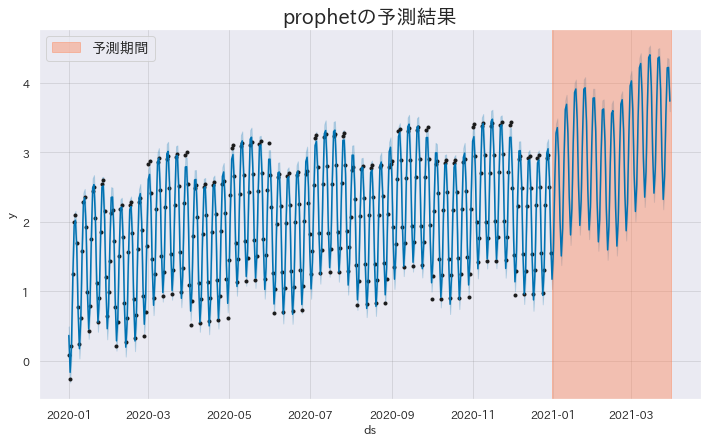

In [7]:
# 予測結果を確認する
periods = 90
m, forecast = train_and_forecast_pf(
    df, periods=periods, yearly_seasonality=True, daily_seasonality=True
)
fig = m.plot(forecast)
plt.title("prophetの予測結果")
plt.axvspan(18627, 18627 + periods, color="coral", alpha=0.4, label="予測期間")
plt.legend()